In [3]:
from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models.CircuitLevelNoise import CircuitLevelNoise
from main.compiling.syndrome_extraction.extractors.ancilla_per_check.mixed.CxCyCzExtractor import CxCyCzExtractor
from main.codes.tic_tac_toe.HoneycombCode import HoneycombCode
from main.codes.tic_tac_toe.gauge_honeycomb_code import GaugeHoneycombCode
from main.codes.tic_tac_toe.FloquetColourCode import FloquetColourCode
from main.codes.tic_tac_toe.TicTacToeCode import TicTacToeCode
from main.utils.enums import State
from main.building_blocks.pauli import Pauli
from main.building_blocks.pauli.PauliLetter import PauliLetter
import stim
import sinter 
import matplotlib.pyplot as plt
import numpy as np
from beliefmatching import BeliefMatchingSinterDecoder
from main.utils.Colour import Blue, Green, Red


class HoneycombCodeZ(TicTacToeCode):
    """Adaptation of the Honeycomb code where the measurement order has been permuted
    """
    def __init__(self, distance: int):
        tic_tac_toe = [
                (Blue, PauliLetter('Z')),
                (Red, PauliLetter('X')),
                (Green, PauliLetter('Y'))]

        super().__init__(distance, tic_tac_toe)

# load the data.
# seperate running and loading.



# Help functions

In [4]:
def calculate_threshold(code_name, distances, observable_index, layer_factor,pers):
    tasks = []
    if code_name == "HoneycombCodeX":
        code = HoneycombCode
    elif code_name == "HoneycombCodeZ":
        code = HoneycombCodeZ
    elif code_name == "GaugeHoneycombCodeX":
        code = GaugeHoneycombCode
    elif code_name == "FloquetColourCodeX":
        code = FloquetColourCode
    

    for d in distances:
        for index, p in enumerate(pers):

            # generate circuit
            if code_name[-1] == 'X':
                circuit = get_X_stim_circuit(code(d), observable_index,layer_factor*d, p)
            elif code_name[-1] == 'Z':
                circuit = get_Z_stim_circuit(code(d), observable_index, layer_factor*d, p)
            tasks.append(sinter.Task(
                    circuit=circuit,
                    detector_error_model=circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True, ignore_decomposition_failures=True),
                    json_metadata={
                        'code': code_name,
                        'distance': d,
                        'p': p,
                        'layers': layer_factor*d}))

    samples = sinter.collect(
        tasks=tasks,
        hint_num_tasks=len(tasks),
        num_workers=10,
        max_shots=5000,
        max_errors=500,
        decoders=['pymatching','beliefmatching'],
        custom_decoders={'beliefmatching': BeliefMatchingSinterDecoder()},
        print_progress=True,
        save_resume_filepath=f'./resume/{code_name}_{observable_index}_{layer_factor}.json',)
    return(samples)


def get_X_stim_circuit(code,observable_index,layers,p):
    compiler = AncillaPerCheckCompiler(CircuitLevelNoise(p,p,p,p,p), syndrome_extractor=CxCyCzExtractor())
    data_qubits = code.data_qubits.values()
    data_qubit_initial_states = {qubit: State.Plus for qubit in data_qubits}
    final_measurements = [Pauli(qubit, PauliLetter('X')) for qubit in data_qubits]
    logical_observables = [code.logical_qubits[observable_index].x]#, code.logical_qubits[1].x]
    stim_circuit: stim.Circuit = compiler.compile_to_stim(code,layers=layers,initial_states= data_qubit_initial_states, final_measurements=final_measurements,logical_observables=logical_observables)
    return(stim_circuit)

def get_Z_stim_circuit(code,observable_index,layers,p):
    compiler = AncillaPerCheckCompiler(noise_model=CircuitLevelNoise(p,p,p,p,p), syndrome_extractor=CxCyCzExtractor())
    data_qubits = code.data_qubits.values()
    data_qubit_initial_states = {qubit: State.Zero for qubit in data_qubits}
    final_measurements = [Pauli(qubit, PauliLetter('Z')) for qubit in data_qubits]
    logical_observables = [code.logical_qubits[observable_index].z]
    stim_circuit: stim.Circuit = compiler.compile_to_stim(code,layers=layers,initial_states= data_qubit_initial_states, final_measurements=final_measurements,logical_observables=logical_observables)
    return(stim_circuit)

In [5]:
circuit = get_X_stim_circuit(HoneycombCode(5), 0,8,0.1)
circuit2 = get_X_stim_circuit(GaugeHoneycombCode(5),0, 2, 0.1)

|████████████████████████████████████████✗︎ (!) 195/171 [114%] in 0.1s (1633.59/s) 


TypeError: __init__() missing 1 required positional argument: 'gauge_factor'

In [6]:

def dem_histogram(dem):
    weight_dict = dict()
    total_errors = 0
    for dem_object in dem:
        if dem_object.type == "error":
            detector_ids = set()
            observable_ids = set()
            if len(dem_object.targets_copy()) in weight_dict:
                weight_dict[len(dem_object.targets_copy())] += 1
            else:
                weight_dict[len(dem_object.targets_copy())] = 1
            total_errors += 1
            #for target in dem_object.targets_copy():
            #    print('+1')

    print(weight_dict, total_errors)

dem_histogram(circuit.detector_error_model(approximate_disjoint_errors=True))
dem_histogram(circuit2.detector_error_model(approximate_disjoint_errors=True))


{2: 436, 3: 168, 4: 536, 5: 124, 1: 16} 1280


NameError: name 'circuit2' is not defined

In [36]:
gauge_hcc_X0_samples = calculate_threshold('GaugeHoneycombCodeX',[4,8,12], 1,2,np.linspace(0.001,0.003, 5))
# and save data

|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 1.9s (413.45/s)                                         1s)  495/675 [73%] in 1s (357.6/s, eta: 1s) 
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 1.2s (645.54/s)                                        eta: 1s) 
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 1.0s (759.86/s)                                        /675 [82%] in 1s (740.4/s, eta: 0s) 
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 1.2s (655.54/s)                                        
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 1.2s (620.38/s)                                        1s)  ▅▃▁ 669/675 [99%] in 1s (595.1/s, eta: 0s) 
|████████████████████████████████████████✗︎ (!) 1539/1347 [114%] in 8.3s (185.92/s)                                      43/1347 [70%] in 6s (162.7/s, eta: 3s)  1215/1347 [90%] in 7s (178.3/s, eta: 1s) (184.3/s, eta: 0s) (184.1/s, eta: -) (186.4/s, eta

Starting workers...
Finding work...
15 cases left:
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.001}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.001}
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.0015}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.0015}
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.002}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=GaugeHoneycombCodeX,distance=4,layers=8,p=0.002}
        pymatching processes=1  ~core_min

In [37]:
hcc_X0_samples = calculate_threshold('HoneycombCodeX',[4,8,12],1,4,np.linspace(0.001,0.003,5))
#hcc_X1_samples = calculate_threshold('HoneycombCodeX',[4,8,12],1,2,np.logspace(-2.2,-1.9,10))

|████████████████████████████████████████✗︎ (!) 387/339 [114%] in 0.4s (872.64/s)                                        
|████████████████████████████████████████✗︎ (!) 387/339 [114%] in 0.3s (1283.02/s)                                       
|████████████████████████████████████████✗︎ (!) 387/339 [114%] in 0.3s (1334.71/s)                                       
|████████████████████████████████████████✗︎ (!) 387/339 [114%] in 0.3s (1381.70/s)                                       
|████████████████████████████████████████✗︎ (!) 387/339 [114%] in 0.3s (1364.29/s)                                       
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 2.2s (343.30/s)                                        █▆▄ 238/675 [35%] in 1s (228.3/s, eta: 3s)  536/675 [79%] in 2s (318.4/s, eta: 1s)  ▁▃▅ 591/675 [88%] in 2s (327.3/s, eta: 0s) 
|████████████████████████████████████████✗︎ (!) 771/675 [114%] in 2.3s (331.76/s)                                        /675 [50%] in 1s (24

Starting workers...
Finding work...
15 cases left:
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.001}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.001}
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.0015}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.0015}
        pymatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.002}
    beliefmatching processes=1  ~core_mins_left=None    shots_left=5000     errors_left=500     {code=HoneycombCodeX,distance=4,layers=16,p=0.002}
        pymatching processes=1  ~core_mins_left=None    shots_lef

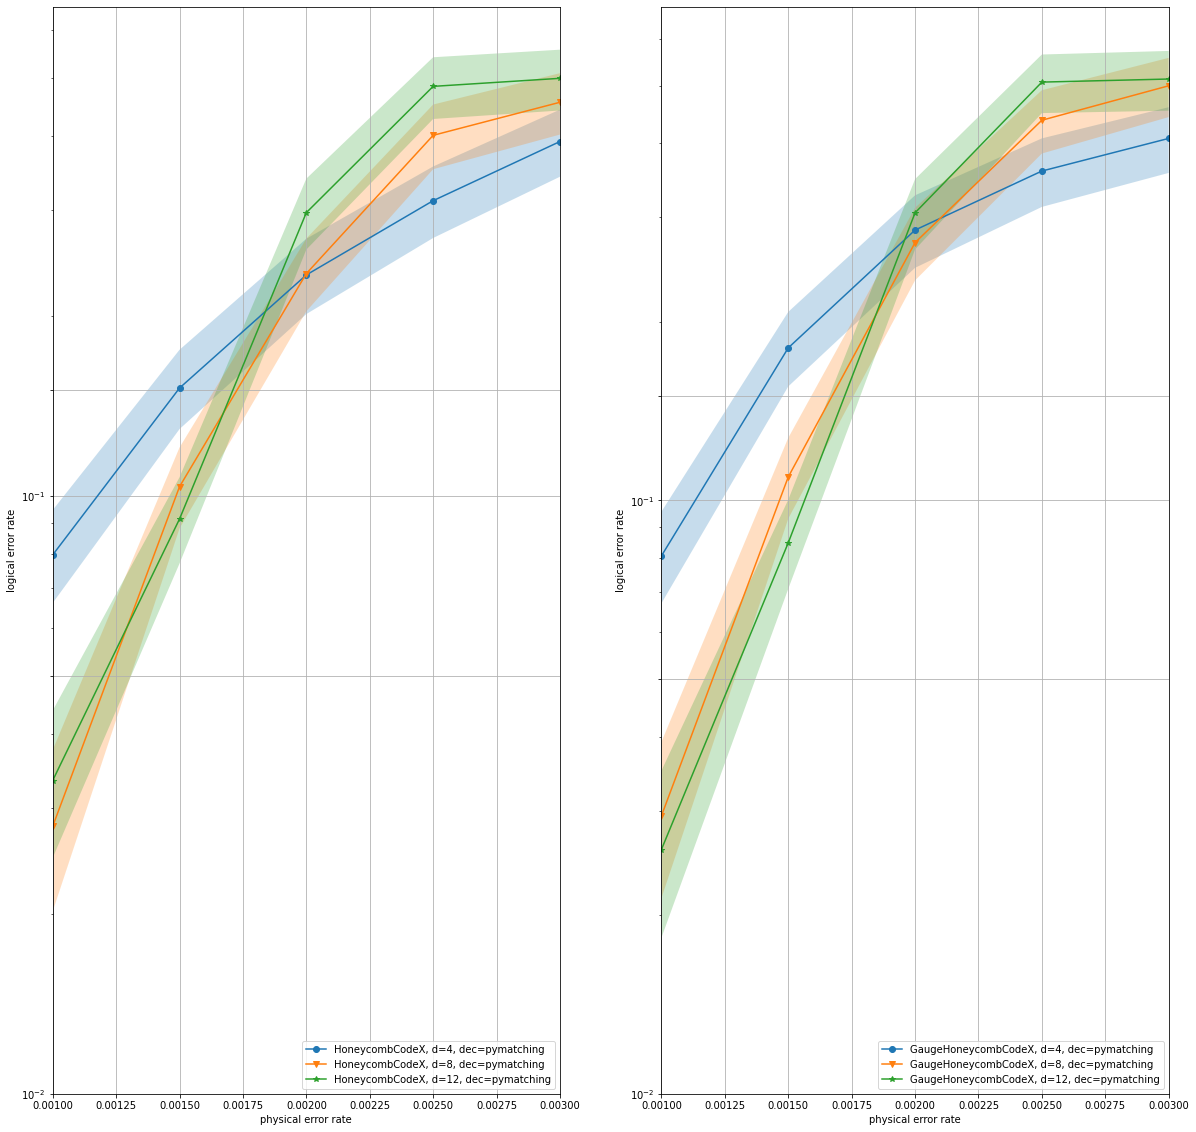

In [47]:
fig, axis = plt.subplots(1, 2,figsize=(20,20))
sinter.plot_error_rate(
        ax=axis[0],
        stats=hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'pymatching',
        x_func=lambda stat: stat.json_metadata['p'])

sinter.plot_error_rate(
        ax=axis[1],
        stats=gauge_hcc_X0_samples,
        group_func=lambda stat: f"GaugeHoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'pymatching',
        x_func=lambda stat: stat.json_metadata['p'])

#print(hcc_samples)
# add a grid to the plot
for ax in axis:
    ax.set_xlim(0.001, 0.003)
    ax.set_yscale('log')
    ax.set_xlabel('physical error rate')
    ax.set_ylabel('logical error rate')
    ax.legend(loc='lower right')
    # add more ticks to the y-axis
    ax.set_yticks([0.01,0.05, 0.1,0.15])
    ax.grid()

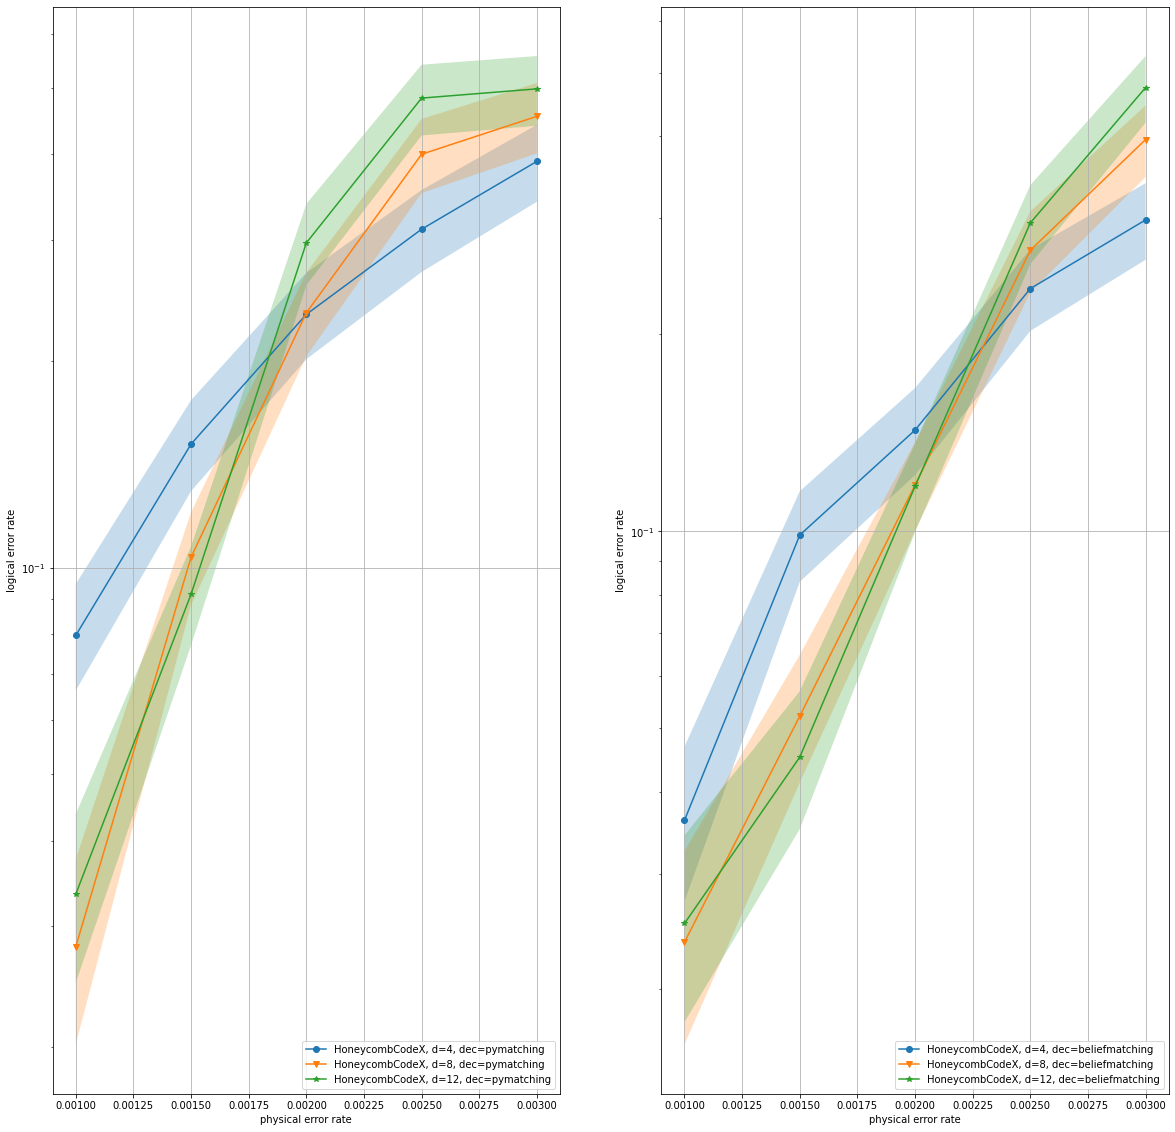

In [49]:
fig, axis = plt.subplots(1, 2,figsize=(20,20))
sinter.plot_error_rate(
        ax=axis[0],
        stats=hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'pymatching',
        x_func=lambda stat: stat.json_metadata['p'])

sinter.plot_error_rate(
        ax=axis[1],
        stats=hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'beliefmatching',
        x_func=lambda stat: stat.json_metadata['p'])

#print(hcc_samples)
for ax in axis:
    ax.set_yscale('log')
    ax.set_xlabel('physical error rate')
    ax.set_ylabel('logical error rate')
    ax.legend(loc='lower right')
    ax.grid()

NameError: name 'gauge_hcc_X0_samples' is not defined

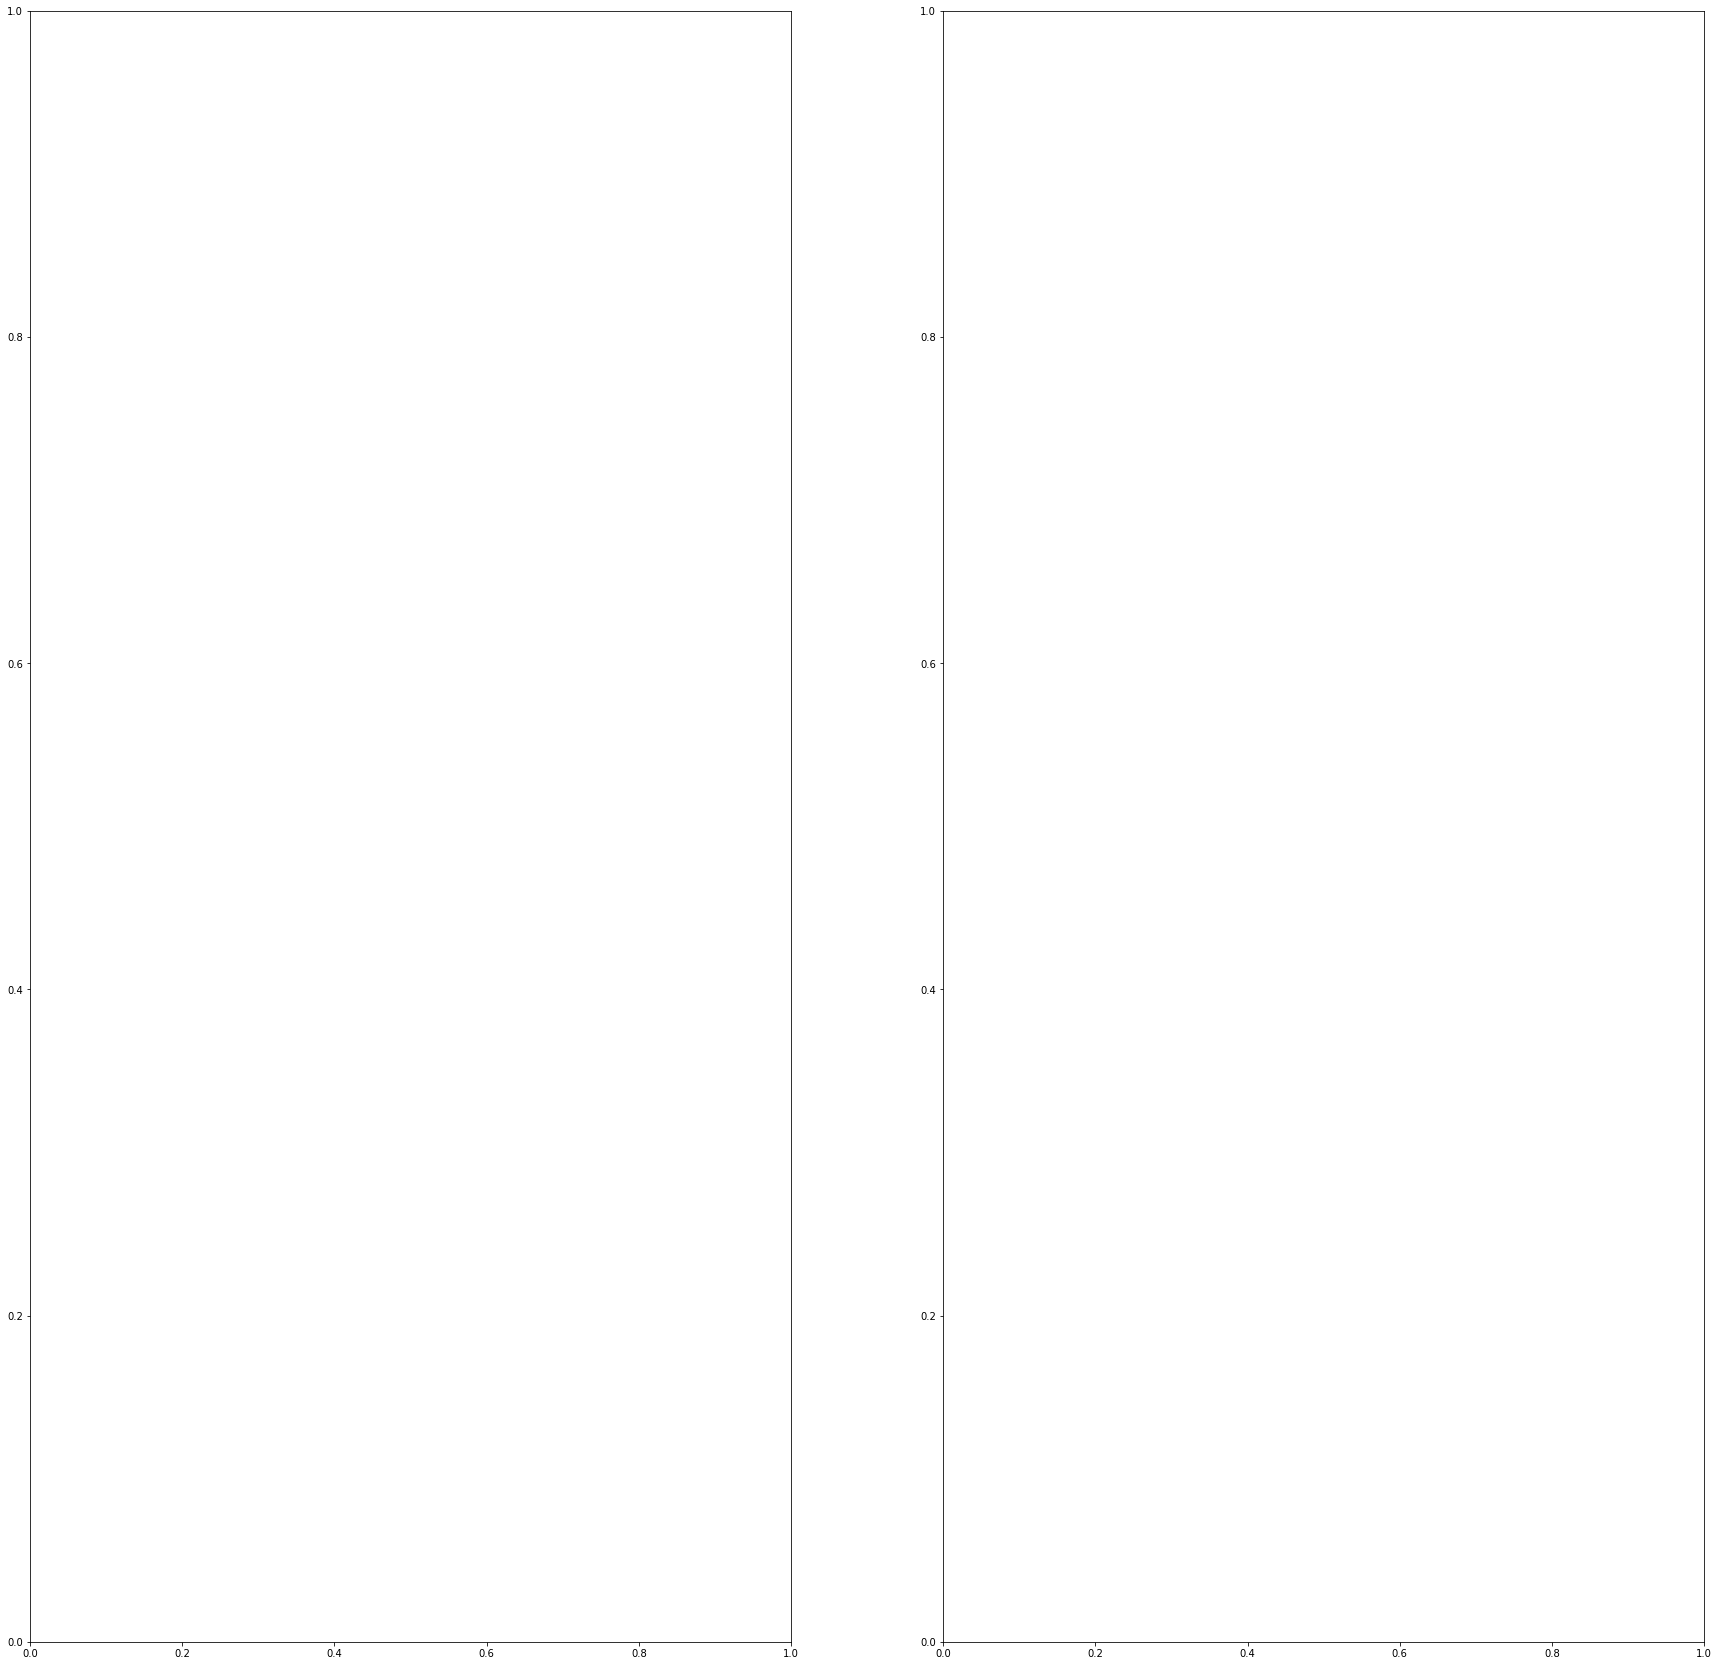

In [34]:
fig, axis = plt.subplots(1, 2,figsize=(30,30))
sinter.plot_error_rate(
        ax=axis[0],
        stats=gauge_hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        #filter_func=lambda s: s.decoder == 'pymatching',
        x_func=lambda stat: stat.json_metadata['p'])

sinter.plot_error_rate(
        ax=axis[1],
        stats=gauge_hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'beliefmatching',
        x_func=lambda stat: stat.json_metadata['p'])

#print(hcc_samples)
for ax in axis:
    ax.set_yscale('log')
    ax.set_xlabel('physical error rate')
    ax.set_ylabel('logical error rate')
    ax.legend(loc='lower right')
    ax.grid()

In [19]:
sinter.plot_error_rate(
        ax=axis[0],
        stats=hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'beliefmatching',
        x_func=lambda stat: stat.json_metadata['p'])

sinter.plot_error_rate(
        ax=axis[1],
        stats=gauge_hcc_X0_samples,
        group_func=lambda stat: f"HoneycombCodeX, d={stat.json_metadata['distance']}, dec={stat.decoder}",
        filter_func=lambda s: s.decoder == 'beliefmatching',
        x_func=lambda stat: stat.json_metadata['p'])

In [ ]:
hcc_circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True).diagram(type="match-graph-3d")

In [12]:
hcc_Z0_samples = calculate_threshold('HoneycombCodeZ',[4,8,12],0,2,np.zeros(10), np.zeros(10),np.logspace(-2.2,-1.9,10),np.zeros(10))
hcc_Z1_samples = calculate_threshold('HoneycombCodeZ',[4,8,12],1,2,np.zeros(10), np.zeros(10),np.logspace(-2.2,-1.9,10),np.zeros(10))

|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.5s (410.29/s)                                        ta: 0s) 
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (563.92/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (610.27/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (718.99/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (709.17/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (699.80/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (664.03/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (622.34/s)                                        
|███████████████

Starting workers...
30 cases left:
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.00630957344480193}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.00630957344480193}
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.006812920690579608}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.006812920690579608}
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.007356422544596414}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers

|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (728.45/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (710.03/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (726.22/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (712.66/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (725.65/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (724.16/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.2s (795.35/s)                                        
|████████████████████████████████████████✗︎ (!) 195/194 [101%] in 0.3s (778.50/s)                                        
|███████████████████████

Starting workers...
30 cases left:
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.00630957344480193}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.00630957344480193}
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.006812920690579608}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.006812920690579608}
        pymatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers=8,mer=0.0,per_x=0.0,per_y=0.0,per_z=0.007356422544596414}
    beliefmatching processes=1  ~core_mins_left=None    (initializing...) {code=HoneycombCodeZ,distance=4,layers